In [33]:
import sys
sys.path.append("../src")
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from clustering import KMeansAuthors, ModHausdorffDocument
from style_point_cloud import style_point_cloud

# Progress bar
from tqdm import tqdm 
tqdm.pandas()

In [34]:
df = pd.read_json("../data/gutenberg_sample.json")

# No need to clean the text here, as it is already in good shape. We only need to lowercase it, since
# we assume it.
df.text = df.text.apply(lambda x: x.lower())

# Generate point cloud for each text. Since this is shorter, we must
# take less tokens
df["point_cloud"] = df.text.progress_apply(lambda text: style_point_cloud(text, window_size=1_000, window_overlap=200, max_tokens=10_000))

# Remove documents with no points
df = df[df.point_cloud.apply(len) > 0].copy()

100%|██████████| 60/60 [00:56<00:00,  1.06it/s]


In [35]:
# Create an author label for each point
auth_labels = [[author]*n_chunks for author, n_chunks in 
                zip(df.author, df.point_cloud.apply(len))]

# Flatten
auth_labels = [x for y in auth_labels for x in y]

In [44]:
data = StandardScaler().fit_transform(np.vstack(df.point_cloud))
X = PCA(n_components=3).fit_transform(data)

cl = KMeansAuthors(n_authors=3)

In [45]:
cl.fit(X, auth_labels)
cl.best_score

0.517829457364341

In [47]:
# Document accuracy
(df.author == cl.predict_document(X, df.point_cloud.apply(len).to_numpy())).sum() / df.author.shape[0]

0.5833333333333334

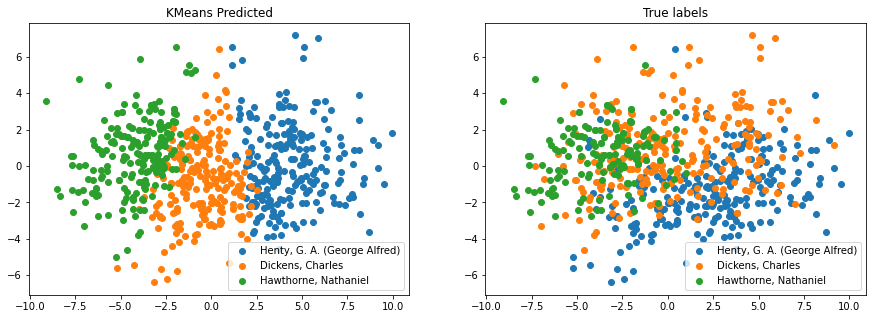

In [48]:
predictions = cl.predict(X, author_labels=True)
auth_idx = dict(zip(set(predictions), range(len(set(predictions)))))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
for label in set(predictions): 
    mask_pred = [True if pr == label else False for pr in predictions]
    mask_true = [True if pr == label else False for pr in auth_labels]
    ax1.scatter(X[:, 0][mask_pred], X[:, 1][mask_pred], label=label)
    ax2.scatter(X[:, 0][mask_true], X[:, 1][mask_true], label=label)
    ax1.legend()
    ax2.legend()
    ax1.set_title("KMeans Predicted")
    ax2.set_title("True labels")

In [49]:
mhcl = ModHausdorffDocument(n_authors=3)

In [50]:
mhcl.fit(X, doc_lengths=df.point_cloud.apply(len).to_numpy(), author_labels=df.author)

In [51]:
mhcl.best_score

0.6333333333333333